# SUP ML 2 - MODEL

# Libraries

In [ ]:
pip install shap==0.45.0

In [ ]:
import shap

In [ ]:
shap.__version__

'0.45.0'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns',None)

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from sklearn.preprocessing import StandardScaler          #escalar variables numericas
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import pickle
from sklearn.model_selection import RandomizedSearchCV    #usar parametros aleatorios para la Hiperparametrizacion (HP)

In [ ]:
#Modelos de clasificacion
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Funciones

In [ ]:
# Funcion que calcula el AUC de un modelo sobre un dataset (X-y). Args: modelo a validar, X, y
def auc(model,X,y):
  model.fit(X,y)
  return roc_auc_score(y,model.predict_proba(X)[:,1])

# Funcion que calcula el AUC en Cross-Validation (X-y). Args: modelo a validar, X, y
def auc_cross_validation(model,X,y):
  cross_val = cross_val_score(model,
                              X, y,
                              cv=4,                 # Numero de folds que vamos a utilizar para validar
                              scoring='roc_auc'     # La metrica de validacion que se medira en cada train-valida
                              )
  return cross_val.mean()

In [ ]:
# Inicializa resultados
label_, auc_train_ , auc_valida_ = [], [], []

# Completa un registro en dataframe con los resultados de las funciones definidas previsamente ( AUC y AUC con cross-validation)

# Inputs:
#   * modelo
#   * (X,y)
#   * label especifico si queremos registrar el resultado con otro nombre (opcional)


def evaluate_classification(model, X, y, label=None):
  if label is None:
    label=str(model)
  label_.append(label)

  auc_train = auc(model,X,y)
  auc_valida = auc_cross_validation(model,X,y)
  auc_train_.append(auc_train)
  auc_valida_.append(auc_valida)

  return pd.DataFrame({'Model': label_,
                      'AUC Train': auc_train_,
                      'AUC Cross-Valida': auc_valida_
                      }).sort_values('AUC Cross-Valida',ascending=False)

# Carga clean data

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Entregable/ML/DSC1123BCN – Entregable 2 - Avelar-Mas-Salcedo-Steel/data/TT_churn_clean.csv",index_col=0)

# Split X-y

In [ ]:
print('Definimos el target = "churn"')
target='churn'

features = df.columns[df.columns != target]

Definimos el target = "churn"


In [ ]:
y = df[target]
X = df[features]

print('Definimos X e y.')

Definimos X e y.


# Distribución del target

[]

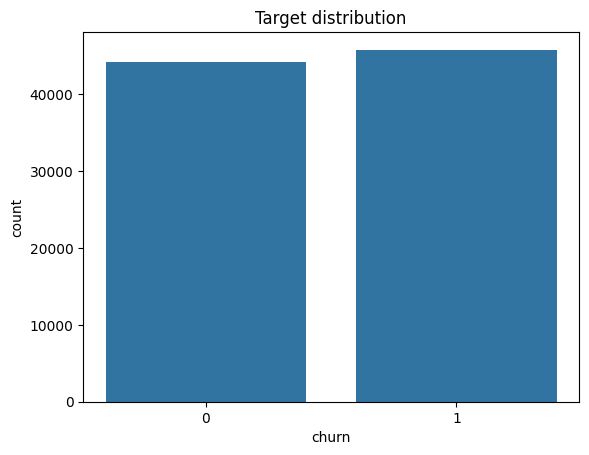

In [ ]:
sns.countplot(data=df,x='churn')
plt.title('Target distribution')
plt.plot()

# Undersampling (*)

**NOTA:** SOLO EN CLASIFICACIÓN cuando el ratio de éxitos está MUY DESBALANCEADO (<10%).

In [ ]:
print('Observamos la distribución en % del dataset')
dist=y.value_counts() / df.shape[0]  # Distribucion en % # dataset balanceado
print(dist)
print('Concluimos que se encuentra balanceado.')

Observamos la distribución en % del dataset
1    0.508889
0    0.491111
Name: churn, dtype: float64
Concluimos que se encuentra balanceado.


In [ ]:
print('Cambiamos el orden de las filas del dataset original.')
df2 = df.sample(frac=1, random_state=42)
X = df2[features]
y = df2[target]

Cambiamos el orden de las filas del dataset original.


# Split TRAIN-TEST

In [ ]:
print('Realizamos el Split Train-Test. \nConsideramos HOLDOUT, 20 % para validar/test')
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        test_size = 0.20, # tamaño del split aleatorio
                                        shuffle = False
                                        #stratify=y
                                    )

Realizamos el Split Train-Test. 
Consideramos HOLDOUT, 20 % para validar/test


# Rescaling

* NO NECESARIO en modelos de Arboles de Decisión.
* Guardar scaler en el model path.

In [ ]:
print('Estandarización: lo usaremos para modelos de lineares, de distancias y redes neuronales.')
scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train)

X_train_std = pd.DataFrame(X_train_std, columns = X_train.columns, index= X_train.index)

Estandarización: lo usaremos para modelos de lineares, de distancias y redes neuronales.


In [ ]:
X_train_std.head(3)

,mou,change_mou,drop_vce,drop_dat,blck_vce,blck_dat,unan_vce,unan_dat,plcd_dat,recv_vce,cc_mou,threeway,mou_cvce,mou_cdat,mou_rvce,owylis_vce,mouowylisv,iwylis_vce,mouiwylisv,peak_vce,peak_dat,mou_peav,opk_vce,opk_dat,mou_opkv,drop_blk,complete,callwait,months,uniqsubs,actvsubs,crclscod,asl_flag,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6rev,hnd_price,income,eqpdays,kids_suma,refurb_new_R,hnd_webcap_U,hnd_webcap_WC,hnd_webcap_WCMB,truck_N,rv_N,rv_Y,forgntvl_N,forgntvl_Y,creditcd_N,creditcd_U
Customer_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1089611,-0.019853,0.090431,-0.624185,-0.160311,-0.344088,-0.109495,-0.385221,-0.173754,-0.407305,0.068624,-0.872202,-0.593712,-0.676568,-0.381938,0.139546,-0.692310,-0.560683,-0.378743,-0.399338,-0.287075,-0.30574,-0.377623,-0.178380,-0.316906,-0.324942,-0.604018,-0.514052,1.007724,-0.902406,0.510725,-0.573510,0.611209,-0.364156,-0.020048,-0.407421,-0.324233,1.138278,-0.125789,-0.015330,-0.495525,-0.390776,0.654836,0.128077,0.091593,-1.751185,-0.302210,-0.492382,-0.417059,-0.349038,-0.407514,0.578911,0.517392,0.337714,-0.306636,0.284405,-0.249049,1.540607,-0.129248
1012457,0.007310,0.122753,-0.394160,-0.160311,0.751257,-0.109495,-0.358680,-0.173754,-0.407305,-0.079893,1.146524,1.684319,-0.293426,-0.381938,-0.107788,-0.516104,-0.538508,-0.294783,-0.259584,0.301864,-0.30574,0.164628,-0.492455,-0.316906,-0.552044,0.298052,-0.135501,1.007724,0.961034,0.510725,1.000565,0.369328,-0.364156,-0.122887,-0.295234,-0.085368,-0.688997,-0.658835,-0.449105,-0.455496,-0.213685,-0.536301,0.123955,0.080171,0.571116,-0.857748,2.242756,-0.417059,-0.349038,2.453905,-1.727380,0.517392,0.337714,-0.306636,-3.516110,4.015280,-0.649095,-0.129248
1053404,0.012192,0.077355,-0.164134,-0.160311,0.187937,-0.109495,0.145597,-0.173754,-0.407305,-0.001726,1.146524,-0.593712,-0.417689,-0.381938,-0.067060,0.267031,-0.327456,1.006596,0.755079,-0.080947,-0.30574,-0.324331,0.172644,-0.316906,-0.225611,0.034032,0.005750,1.007724,-0.792791,-0.626994,-0.573510,0.127448,-0.364156,-0.487924,-0.367517,-0.292940,-0.134369,-0.140297,-0.041601,-0.182922,0.046744,-0.103160,0.125248,0.093878,0.570930,-0.159358,-0.492382,-0.417059,-0.349038,-0.407514,0.578911,0.517392,0.337714,-0.306636,-3.516110,4.015280,-0.649095,-0.129248


# TRAIN-VALIDA

## Torneo de Modelos

* Probamos una colección de modelos con el objetivo de conseguir el mejor rendimiento del modelo en los datos de VALIDACION.

LogisticRegression() clasificacion estandarizar

RandomForestClassifier() ensemble
XGBClassifier() ensemble
LGBMClassifier() ensemble
GradientBoostingClassifier ensemble

MLPClassifier neural network
GaussianNB probabilidad
KNeighborsClassifier() similitud


In [ ]:
print("Entrenamos varios modelos utilizando diferentes algoritmos, evaluándolos con el AUC(Área bajo la curva ROC) en dataset de train y cross-validation(4).")

modelos=[RandomForestClassifier(),XGBClassifier(),LGBMClassifier(),GradientBoostingClassifier(),GaussianNB(),LogisticRegression(),MLPClassifier(),KNeighborsClassifier()]
label_.clear()
auc_train_.clear()
auc_valida_.clear()
stdmodels=[LogisticRegression(),MLPClassifier(),KNeighborsClassifier()] #modelos que se les aplicara el dataset estandarizado
for i in modelos:
  if i in stdmodels:
    model=i
    modelcomp=evaluate_classification(model,X= X_train_std,y=y_train)
  else:
    model=i
    modelcomp=evaluate_classification(model,X= X_train,y=y_train)


modelcomp

Entrenamos varios modelos utilizando diferentes algoritmos, evaluándolos con el AUC(Área bajo la curva ROC) en dataset de train y cross-validation(4).
[LightGBM] [Info] Number of positive: 36643, number of negative: 35357
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7602
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508931 -> initscore=0.035726
[LightGBM] [Info] Start training from score 0.035726
[LightGBM] [Info] Number of positive: 27482, number of negative: 26518
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=tru

,Model,AUC Train,AUC Cross-Valida
2,LGBMClassifier(),0.734487,0.667610
3,GradientBoostingClassifier(),0.679070,0.663012
1,"XGBClassifier(base_score=None, booster=None, c...",0.831268,0.649557
0,RandomForestClassifier(),1.000000,0.645198
5,LogisticRegression(),0.576959,0.576529
4,GaussianNB(),0.553382,0.553003
7,KNeighborsClassifier(),0.775876,0.552943
6,MLPClassifier(),0.577816,0.538267


## Hiperparametrizacion

* Utilizar RandomSearch para probar diferentes configuraciones de los parametros del modelo ganador en el torneo de modelos con el objetivo de mejorar el control del overfitting.

In [ ]:
#LGBM
print("Definimos un conjunto de parámetros para ajustar el modelo LGBM (LightGBM) utilizando búsqueda de hiperparámetros. \nLos parámetros incluyen opciones como el número de hojas ('num_leaves'), la profundidad máxima del árbol ('max_depth'), regularización L1 ('lambda_l1') y L2 ('lambda_l2'), fracción de características ('feature_fraction'), entre otros.")

parametros = {
  'num_leaves': [10, 50, 100],
    'max_depth': [5, 10, 15],
    'lambda_l1': [0, 0.1, 0.5, 1],
    'lambda_l2': [0, 0.1, 0.5, 1],
    'subsample': [0.5, 0.8, 1],
    'feature_fraction': [0.5, 0.8, 1],
    'min_child_samples': [10, 50, 100]
}

Definimos un conjunto de parámetros para ajustar el modelo LGBM (LightGBM) utilizando búsqueda de hiperparámetros. 
Los parámetros incluyen opciones como el número de hojas ('num_leaves'), la profundidad máxima del árbol ('max_depth'), regularización L1 ('lambda_l1') y L2 ('lambda_l2'), fracción de características ('feature_fraction'), entre otros.


In [ ]:
print("Realizamos una búsqueda aleatoria de hiperparámetros para el modelo LGBMClassifier utilizando RandomizedSearchCV. \nSe prueba un conjunto de combinaciones aleatorias de hiperparámetros definidos en el diccionario 'parametros' \ncon el objetivo de maximizar el rendimiento en términos de AUC (Área bajo la curva ROC) mediante validación cruzada con 5 folds.")

search_hp = RandomizedSearchCV(estimator=LGBMClassifier(),
                               param_distributions = parametros,
                               scoring='roc_auc',
                               cv = 4,                                    # numero de folds para cross-validation
                               n_iter = 20,                               # numero de iteraciones, cada una testeara una configuracion distinta
                               n_jobs=-1,
                               random_state=42

                               )

Realizamos una búsqueda aleatoria de hiperparámetros para el modelo LGBMClassifier utilizando RandomizedSearchCV. 
Se prueba un conjunto de combinaciones aleatorias de hiperparámetros definidos en el diccionario 'parametros' 
con el objetivo de maximizar el rendimiento en términos de AUC (Área bajo la curva ROC) mediante validación cruzada con 5 folds.


In [ ]:
search_hp.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Info] Number of positive: 36643, number of negative: 35357
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7602
[LightGBM] [Info] Numbe

RandomizedSearchCV(cv=4, estimator=LGBMClassifier(), n_iter=20, n_jobs=-1,
                   param_distributions={'feature_fraction': [0.5, 0.8, 1],
                                        'lambda_l1': [0, 0.1, 0.5, 1],
                                        'lambda_l2': [0, 0.1, 0.5, 1],
                                        'max_depth': [5, 10, 15],
                                        'min_child_samples': [10, 50, 100],
                                        'num_leaves': [10, 50, 100],
                                        'subsample': [0.5, 0.8, 1]},
                   random_state=42, scoring='roc_auc')

In [ ]:
print("---- Results from Random Search -----" )
print("\n The best estimator across ALL searched params:", search_hp.best_estimator_)
print("\n The best AUC_ROC:", search_hp.best_score_)
print("\n The best parameters across ALL searched params:\n", search_hp.best_params_)

---- Results from Random Search -----

 The best estimator across ALL searched params: LGBMClassifier(feature_fraction=0.5, lambda_l1=1, lambda_l2=1, max_depth=5,
               min_child_samples=100, num_leaves=50, subsample=1)

 The best AUC_ROC: 0.6691701505288259

 The best parameters across ALL searched params:
 {'subsample': 1, 'num_leaves': 50, 'min_child_samples': 100, 'max_depth': 5, 'lambda_l2': 1, 'lambda_l1': 1, 'feature_fraction': 0.5}


**Argumento en una celda de texto la selección del mejor modelo**

#### Por sus resultados en train y cross validation el mejor modelo es el LGBMClassifier. Esta eleccion tambien se basa por su eficiencia y rendimiento en bases de datos de gran escala.Y ademas por proporcionar metricas de evaluación claras y detalladas, como la precisión, recall y F1 score. Estas son fundamentales para comprender y valorar adecuadamente el desempeño del modelo en la clasificación del churn.


## Modelo final

* Entrenar el modelo final con el algoritmo y los parametros que hanfuncionado mejor en anteriores experimentos.
* Argumentar la elección.
* Guardar el modelo en model path.

In [ ]:
best_model= search_hp.best_estimator_

# TEST

* Evaluación de las métricas de performance en TEST.

In [ ]:
print('Realizamos predicciones del modelo en los datos de TRAIN')
y_train_pred = best_model.predict(X_train)                        # predicciones del modelo en los datos de TRAIN
y_test_pred = best_model.predict(X_test)

Realizamos predicciones del modelo en los datos de TRAIN
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1


In [ ]:
print('Definimos la probabilidad de éxito (1) segun el modelo en los datos de TRAIN')
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]      # probabilidad de éxito (1) segun el modelo en los datos de TRAIN
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

Definimos la probabilidad de éxito (1) segun el modelo en los datos de TRAIN
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1


In [ ]:
auc_train = roc_auc_score(y_train, y_train_pred_proba)      # AUC en TRAIN
auc_test = roc_auc_score(y_test, y_test_pred_proba)         # AUC en TEST

In [ ]:
print('AUC Train:', round(auc_train,4))
print('AUC Test:', round(auc_test,4))

AUC Train: 0.7089
AUC Test: 0.6716


In [ ]:
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

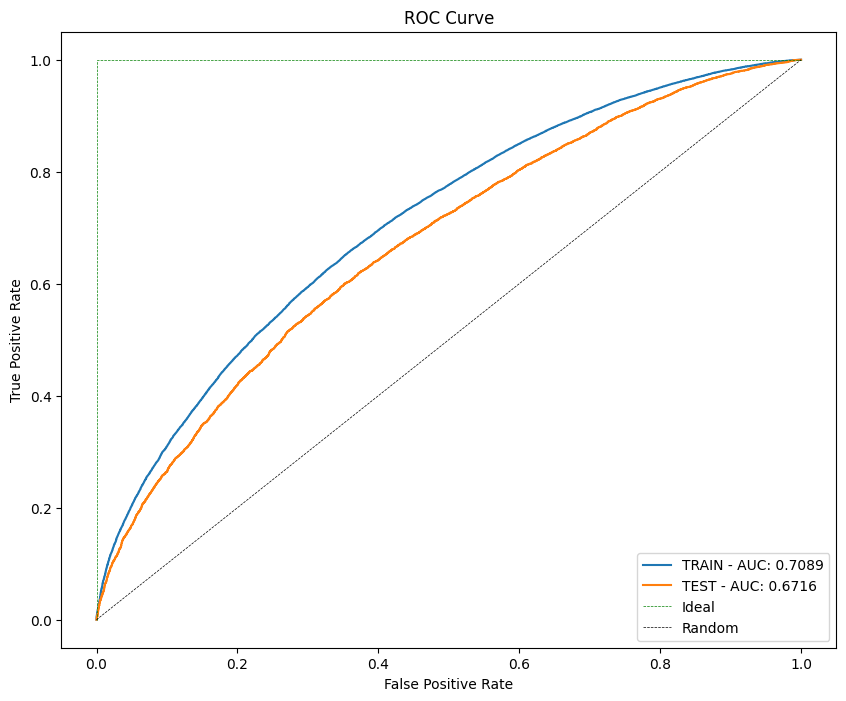

In [ ]:
#Plot
plt.figure(figsize=[10,8])
plt.plot(fpr_train, tpr_train, label='TRAIN - AUC: {:.4f}'.format(auc_train))
plt.plot(fpr_test, tpr_test, label='TEST - AUC: {:.4f}'.format(auc_test))
plt.title('ROC Curve')
plt.plot([0,0,1],[0,1,1], color='green', linestyle='--', linewidth=0.5, label='Ideal')
plt.plot([0, 1], [0, 1], color='black', linestyle='--', linewidth=0.5, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [ ]:
cm_test = confusion_matrix(y_test, y_test_pred)

[]

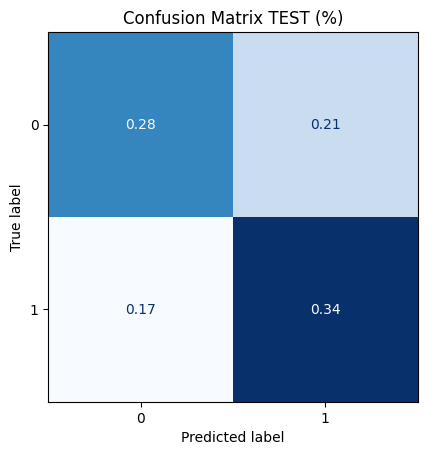

In [ ]:
ConfusionMatrixDisplay(confusion_matrix=cm_test/len(y_test)).plot(colorbar = False, cmap = 'Blues')
plt.title('Confusion Matrix TEST (%)')
plt.plot()

In [ ]:
print('Accuracy:', round( accuracy_score(y_test, y_test_pred),4))
print('Precision:', round( precision_score(y_test, y_test_pred), 4))
print('Recall:', round( recall_score(y_test, y_test_pred), 4))
print('F1-score:', round(f1_score(y_test, y_test_pred), 4))

Accuracy: 0.6212
Precision: 0.6188
Recall: 0.6652
F1-score: 0.6412


# INTERPRETABILITY

* Analizamos top features del modelo y su peso en el modelo.
* Plotear SHAP values y el impacto positivo/negativo.
* Comentar las top5 features, su impacto en el target y extraer insights.
* Analisis complementarios:
  * Modelos de arboles: Feature Importances, plot de arbol de decision.
  * Modelos lineales: Coeficentes y formula del modelo.

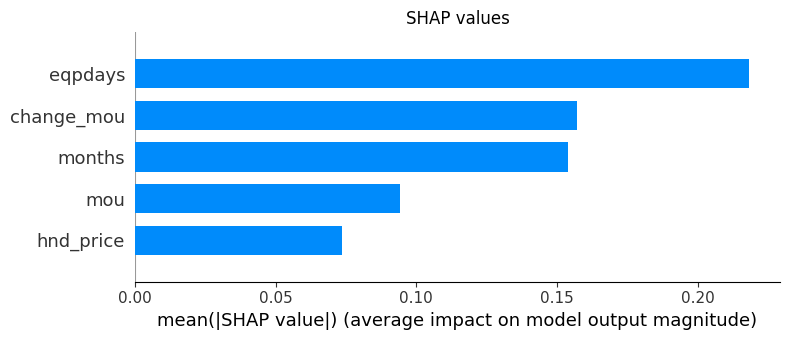

In [ ]:
#SHAP value: peso en el output final
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
plt.title('SHAP values')
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=5)


Los SHAP values nos indican ademas el sentido del impacto que tiene la variable en la predicción (positivo/negativo):

Rojo a la derecha = POSITIVO (+)
Rojo a la izquierda = NEGATIVO (-)

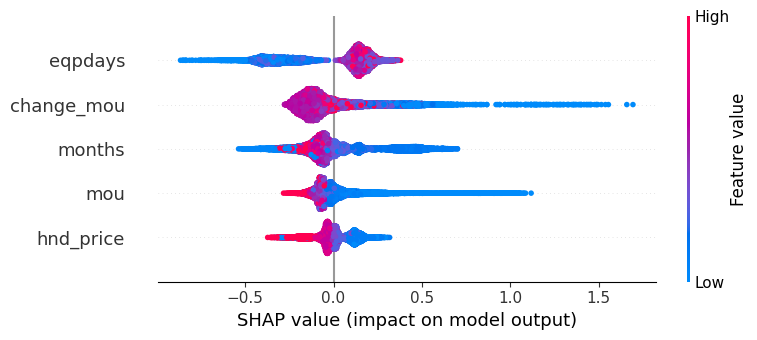

In [ ]:
shap.summary_plot(shap_values,X_test,plot_type="dot", max_display=5)

eqpdays= Número de días (edad) del equipo actual: Si la edad del equipo actual el cliente es alta, estaria buscando renovar su equipo, lo que es probable que busque ofertas en otras empresas y termine abandonando.

---
change_mou= Este tiene un impacto directo sobre el análisis de predicción de clientes que potencialmente podrían dejar de usar el servicio. Por ejemplo, un una bajada del uso del servicio puede ser un indicador que abandonara.

---

months= Otro factor con un impacto directo y crucial. Ya que usualmente cuando un cliente tiene un tiempo mas largo siendo cliente del servicio, suelen ser clientes "leales". Mientras que clientes "nuevos" suelen ser clientes que experimentas el servicio, su calidad, etc y suele ser este segmento de clientes donde puede estar el mayor porcentaje de aquellos que abandonan.

---

mou= Si el numero de minutos medios es alto, el cliente esta conforme con el servicio por lo tanto es poco probable que abandone.

---

hnd_price= A medida que el precio de equipo sea bajo aumenta la prediccion de abandono.







In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Entregable/ML/DSC1123BCN – Entregable 2 - Avelar-Mas-Salcedo-Steel/model/modelo_entrenado.pkl', 'wb') as archivo:
    pickle.dump(best_model, archivo)